Сегодня поговорим о частотном анализе

сначала установим и импортируем все необходимые библиотеки

In [1]:
!pip3 -qq install yargy --progress-bar off
!pip3 -qq install pymorphy2 --progress-bar off
!pip3 -qq install rusenttokenize --progress-bar off

import sys
import nltk

# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
        
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

Теперь загрузим и прочитаем данные. Сегодня у нас тексты про тайфун

In [3]:
with open("../data/typhoon.txt", "r") as file:
    text = file.read()


Теперь наши файлы готовы, и можно начинать анализ текстов

# Частотный анализ

Многие компьтерные методы анализа текста основаны на статистике — в нашем случае это частотность символов / словоформ / лексем / биграмм / триграмм / частей речи и т.д., ее отношение к длине текста, средняя длина текстов и т.д.

Зачем нам знать частотность слов в тексте? Например, она говорит о том, какие слова наиболее характеры для того или иного текста. Сравнивая частотные слова в разных текстах можно определить степень их близости, классифицировать по жанру, теме и т.п., а также выявить явления, характерные для языка в целом. 

PS:
- Подход, когда текст представляется просто как куча слов, без информации об их порядке, называется **bag of words**.

- Частотный словарь русского языка, составленный О.Н. Ляшевской и С.А. Шаровым на основе НКРЯ, можно найти [вот тут](http://dict.ruslang.ru/freq.php).


## Закон Ципфа

**Закон Ципфа** («ранг—частота») — эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n (т.н. рангу этого слова). Например, второе по используемости слово встречается примерно в два раза реже, чем первое, третье — в три раза реже, чем первое, и т.д.

$$f = \frac{a}{r}$$
 
$f$ – частота, $r$ – ранг, $a$  – параметр, для славянских языков – около $0.07$

![zipf](https://i.pics.livejournal.com/eponim2008/17443609/234916/234916_original.jpg)

Закон назван именем американского лингвиста Джорджа Ципфа (правда, популяризировал он данную закономерность не для лингвистических данных, а для описания распределения экономических сил и социального статуса). 

**Если закон Ципфа соблюдается — значит, перед нами нормальный текст на естественном языке. Если нет, то что-то с ним не так.**

## Закон Хипса

**Закон Хипса** — эмпирическая закономерность в лингвистике, описывающая распределение числа уникальных слов в документе (или наборе документов) как функцию от его длины. C увеличением длины текста (количества токенов), количество *уникальных* токенов увеличивается сдедующим образом:

$|V| = K*N^b$, &emsp; $N$  –  число токенов, $|V|$  – количество уникальных токенов, $K, b$  –  свободные параметры (определяются эмпирически), обычно $K \in [10,100], b \in [0.4, 0.6]$

![heaps](http://nordbotten.com/ADM/ADM_book/figures/F4-5_Heaps.gif)

**Чем больше коллекция текстов, тем меньше новых токенов появляется с её пополнением**

# Способы считать частоту


## Абсолютная частота слова
Количество употреблений слова в тексте. Она не всегда уместна.



## Относительная частота слова
это отношение его абсолютной частоты к какой-нибудь другой величине, например, к длине текста или корпуса. Существуют разные способы подсчета относительной частоты. 



### IPM
Для сравнения частот в разных коллекциях текстов популярен $ipm$ *(items per million).* Как следует из названия, это отношение абсолютной частоты какого-либо элемента к объему корпуса, умноженное на миллион.

$$ ipm_{word} = \dfrac{f_{word}}V_{corpus} \        \times \  1,000,000 $$ 

Например, если текст состоит из 500 слов, и слово "котик" встречается там 50 раз, то 

$$ ipm_{котик} = \dfrac{50}{500} \       \times \  1,000,000 \     = 100,000 $$ 

Метрика IPM позволяет сравнивать тексты через их характеристики. Например, "Я" заметно чаще встречается в корпусе любительской литературы, чем в корпусе художественных произведений из НКРЯ.



### TF-IDF

Eсли мы возьмём множество документов из какой-то одной и узкой предметной области, они все будут разделять значительное количество одинаковых токенов, характерных для темы.


$\textit{Tf-Idf}$ &mdash; способ высоко оценить слова, которые одновременно
* показательны в документе
* не вездесущи в корпусе документов


оценка слова будет 
* увеличиваться, если оно частотно в документе и уменьшаться
* уменьшаться, если оно встречается во многих документах

В таком противостоянии победят те слова, которые выделяют документы из множества им подобных.

---

$$\textit{Tf-Idf}(\mathit{token}, \mathit{document}, \mathit{corpora}) = \mathit{tf}(\mathit{token}, \mathit{document}) \times \mathit{idf}(\mathit{token}, \mathit{corpora}),$$

$\mathit{tf}$ &mdash; частота токена в документе;
$\mathit{idf}$ &mdash; обратно монотонно частоте токена в корпусе

Классическая функция $\mathit{idf}$ $$\mathit{idf}(\mathit{document}, \mathit{corpora}) = \log{\frac{\left| \mathit{corpora} \right|}
{\left| \{ \mathit{document} \in \mathit{corpora}: \mathit{token} \in \mathit{document} \} \right|}}$$

<br>

<img alt="r/learnmachinelearning - I made an infographic to help me remember how TF–IDF works. Hope this helps someone"  width="600" height="400"
     src="https://i.redd.it/nchhwldrvt251.png">

подробнее про tf-idf можно почитать [здесь](https://ru.wikipedia.org/wiki/TF-IDF) и [здесь](https://medium.com/analytics-vidhya/tf-idf-term-frequency-technique-easiest-explanation-for-text-classification-in-nlp-with-code-8ca3912e58c3)

## Облака слов


Это наглядный способ посмотреть на частоты слов в тексте/корпусе: более встречаемые отображаются крупнее.


<div>
<img src="https://s3.amazonaws.com/nautilus-vertical/mitp-a-170.png" width="400"/>
</div>

А вот пример функции, которая генерирует вордклауд из частотного словаря

In [33]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def show_wordcloud_by_freq_dict(freq_dict):
    
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freq_dict)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# Частотный анализ текстов

давайте проведем серию экспериментов

### Частотный анализ максимально просто 

г.	0.04587155963302752
—	0.03669724770642202
на	0.02140672782874618
и	0.01834862385321101
ноября	0.01529051987767584
августа	0.01529051987767584
сентября	0.01529051987767584
тайфунов	0.012232415902140673
Китай	0.012232415902140673
Филиппины	0.012232415902140673


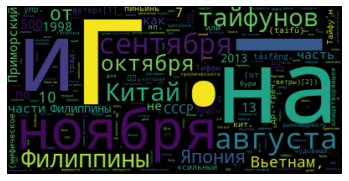

In [43]:
from collections import defaultdict as dd # удобный словарик
from operator import itemgetter # способ доставать n-ый элемент из iterable


with open("../data/typhoon.txt", "r") as file:
    document = file.read()

    text_words_frequencies = dd(int)  # все частоты = 0 

        
    document_tokenized = document.split() # превратили в список
    for word in document_tokenized:
        text_words_frequencies[word] += 1 / len(document_tokenized)
        # теперь частота слова -- это 1/длину списка


    # отсортируем по убыванию
    sorted_frequency_table = sorted(text_words_frequencies.items(), 
                                        key=itemgetter(1), reverse=True) 
    
    # покажем первые 10         
    for word, freq in sorted_frequency_table[:10]:
        print('\t'.join((word, str(freq))))
        
    show_wordcloud_by_freq_dict(text_words_frequencies)
    # print(document)

### Частотный анализ текста,получше

Теперь –– с предобработкой 

In [44]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from rusenttokenize import ru_sent_tokenize
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
morph_analyzer.parse("океан")[0].normal_form

'океан'

	0.1951219512195141
г	0.040650406504065026
—	0.03252032520325208
тайфун	0.02168021680216804
ноябрь	0.01626016260162601
филиппина	0.01626016260162601
япония	0.01355013550135501
август	0.01355013550135501
китай	0.01355013550135501
сентябрь	0.01355013550135501


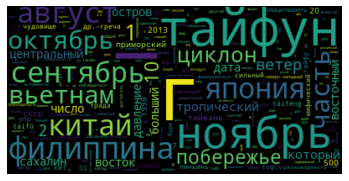

Тайфу́н (от кит. трад. 颱風, упр. 台风, пиньинь táifēng, яп. 台風 (taifū) — «сильный ветер»[1] или от др.-греч. Τυφῶν — Тифон (мифическое чудовище, олицетворявшее бури и ветры)[2]) — разновидность тропического циклона, которая типична для северо-западной части Тихого океана. В центральной части тайфунов наблюдается наибольшее снижение давления воздуха на поверхности моря, достигающее 650 мм рт.ст. (циклон Тайп, 1979).

Зона активности тайфунов, на которую приходится третья часть общего числа тропических циклонов на Земле, заключена между побережьем Восточной Азии на западе, экватором на юге и линией перемены даты на востоке. Хотя большая часть тайфунов формируется с мая по ноябрь, другие месяцы от них также не свободны. Особенно разрушительным был сезон тайфунов 1991 года[en], когда у побережья Японии буйствовало несколько тайфунов давлением 870—878 мбар.

К берегам российского Дальнего Востока тайфуны относит, как правило, после того, как их основной удар принимают на себя Корея, Япония и о

In [66]:
morph_analyzer = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

def preprocess_tokenize(text):
    
    text_preprocessed_tokenized = []
        
    for sentence in ru_sent_tokenize(text):
        
        clean_words = [word.strip(string.punctuation) for word in word_tokenize(text)]
        
        
        clean_words = [word.lower() for word in clean_words if word not in russian_stopwords]
        
        clean_lemmas = [morph_analyzer.parse(word)[0].normal_form for word in clean_words]
        
        text_preprocessed_tokenized.extend(clean_lemmas)

    return text_preprocessed_tokenized


# main func
with open("../data/typhoon.txt", "r") as file:
    document = file.read()

    text_words_frequencies = dd(int)
    document_tokenized = preprocess_tokenize(document)
    for word in document_tokenized:
        text_words_frequencies[word] += 1 / len(document_tokenized)

    sorted_frequency_table = sorted(text_words_frequencies.items(), 
                                    key=itemgetter(1), reverse=True)    

    for word, freq in sorted_frequency_table[:10]:
        print('\t'.join((word, str(freq))))

    show_wordcloud_by_freq_dict(text_words_frequencies)
    print(document)

None


## $\textit{Tf-Idf}$

Если частоты считать аккуратно, то списки частотности более-менее передают контраст документов.  
**Но!** если мы возьмём множество документов из какой-то одной и узкой предметной области -- они все будут разделять значительное количество одинаковых токенов, характерных для темы.


$\textit{Tf-Idf}$ &mdash; способ высоко оценить слова, которые одновременно
* показательны в документе
* не вездесущи в корпусе документов


Наивная идея такая: давайте оценка слова будет 
* увеличиваться, если оно частотно в документе и уменьшаться
* уменьшаться, если оно встречается во многих документах

В таком противостоянии победят те слова, которые выделяют документы из кучи им подобных.

---

$$\textit{Tf-Idf}(\mathit{token}, \mathit{document}, \mathit{corpora}) = \mathit{tf}(\mathit{token}, \mathit{document}) \times \mathit{idf}(\mathit{token}, \mathit{corpora}),$$

$\mathit{tf}$ &mdash; частота токена в документе;
$\mathit{idf}$ &mdash; обратно монотонно частоте токена в корпусе

Классическая функция $\mathit{idf}$ $$\mathit{idf}(\mathit{document}, \mathit{corpora}) = \log{\frac{\left| \mathit{corpora} \right|}
{\left| \{ \mathit{document} \in \mathit{corpora}: \mathit{token} \in \mathit{document} \} \right|}}$$

<br>

подробнее про tf-idf можно почитать [здесь](https://ru.wikipedia.org/wiki/TF-IDF) и [здесь](https://medium.com/analytics-vidhya/tf-idf-term-frequency-technique-easiest-explanation-for-text-classification-in-nlp-with-code-8ca3912e58c3)

### Частотный анализ Ленты с помощью tf-idf

части	0.26595527051888723
от	0.2130568246088831
от	0.2130568246088831
от	0.2130568246088831
颱風	0.13297763525944362
台风	0.13297763525944362
台風	0.13297763525944362
яп	0.13297763525944362
чудовище	0.13297763525944362
циклона	0.13297763525944362


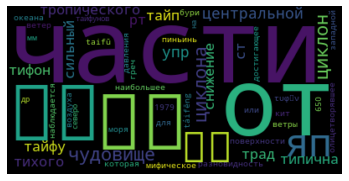

Тайфу́н (от кит. трад. 颱風, упр. 台风, пиньинь táifēng, яп. 台風 (taifū) — «сильный ветер»[1] или от др.-греч. Τυφῶν — Тифон (мифическое чудовище, олицетворявшее бури и ветры)[2]) — разновидность тропического циклона, которая типична для северо-западной части Тихого океана. В центральной части тайфунов наблюдается наибольшее снижение давления воздуха на поверхности моря, достигающее 650 мм рт.ст. (циклон Тайп, 1979).

Зона активности тайфунов, на которую приходится третья часть общего числа тропических циклонов на Земле, заключена между побережьем Восточной Азии на западе, экватором на юге и линией перемены даты на востоке. Хотя большая часть тайфунов формируется с мая по ноябрь, другие месяцы от них также не свободны. Особенно разрушительным был сезон тайфунов 1991 года[en], когда у побережья Японии буйствовало несколько тайфунов давлением 870—878 мбар.

К берегам российского Дальнего Востока тайфуны относит, как правило, после того, как их основной удар принимают на себя Корея, Япония и о

In [76]:
# main func
with open("../data/typhoon.txt", "r") as file:
    document = file.read()
    

sent_text = ru_sent_tokenize(document)
sent_text     
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit_transform(sent_text)
feature_names = tfidf_vectorizer.get_feature_names()
feature_names


X = tfidf_vectorizer.transform(sent_text)

tfixdf_scores = [(feature_names[col], X[0, col]) for col in X.nonzero()[1]]
tfixdf_scores

freq_list = [(word, freq) for word, freq in sorted(tfidf_scores, 
                                                   key=itemgetter(1), 
                                                   reverse=True)]

for word, freq in freq_list[:10]:
        print('\t'.join((word, str(freq))))

show_wordcloud_by_freq_dict(dict(freq_list))
print(document)

## Итог
Так выглядит базовое извлечение ключевых слов из текстов. 
Теперь их можно использовать в дальнейших шагах ваших проектов.